In [262]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Limpieza de los datos



1. Cargar los datos

In [263]:
calificaciones = pd.read_csv("./Datos/calificaciones.csv")
estudiantes = pd.read_csv("./Datos/estudiantes.csv")
carreras = pd.read_csv("./Datos/carrera.csv")
escuelas = pd.read_csv("./Datos/escuelas.csv")

### Primero eliminamos a aquellos estudiantes que su "prepa" no esta registrada como escuela y despues unimos los datasets de estudiantes y escuelas

con esto se quitaron aprox. 2000-3000 filas

In [264]:
ciud = pd.DataFrame(estudiantes["ciudad"].unique(), columns=["ciudad"])
correcta = pd.merge(estudiantes, escuelas[['clave']], left_on='prepa', right_on='clave', how='inner')


### Ahora se filtran todas las calificaciones de alumnos, si la clave del alumno no esta registrada en alumnos se descartan.

In [265]:
correcta2 = pd.merge(calificaciones, estudiantes[['clave_alumno']], left_on='clave_alumno', right_on='clave_alumno', how='inner')
#correcta2.sort_values('clave_alumno')


### Se filtran a aquellos estudiantes que necesitamos solamente, aquellos que siguen vigentes y que no han terminado sus estudios

In [266]:
mainData = estudiantes[(estudiantes['termino'].isnull()) & (estudiantes['causa_salida']==1)]
#correcta3.sort_values('clave_alumno')
mainData

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida
607,3327,4,1,121,BUENOS,25006.0,CULIACAN,2043.0,NaN,1
648,4420,4,1,154,El Walamo,25011.0,GUASAVE,2053.0,NaN,1
662,4434,4,1,127,Alcanfores,25018.0,NAVOLATO,2053.0,NaN,1
668,4440,4,1,117,Los Angeles,25006.0,CULIACAN,2053.0,NaN,1
671,4443,4,1,142,NaN,25002.0,LA REFORMA ANG.,2053.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
11930,11738,8,2,98,Fovissste Playa Azul,25006.0,CULIACAN,2103.0,NaN,1
11931,11739,8,1,91,LA,25006.0,CULIACAN,2103.0,NaN,1
11932,11740,8,1,71,BALCONES,25006.0,CULIACAN,2103.0,NaN,1
11933,11825,8,1,26,San Miguel,25006.0,CULIACAN,2103.0,NaN,1


### Aqui ponemos la clave de los municipios correctos, si encuentra otra clave pone por default la de culiacan

In [267]:
#los municipios con clave le asignamos su ciudad correspondiente
mainData['ciudad'] = mainData['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else 'Juan Jose Rios' if x == 25020 else 'No encontrado')
#para los municipios que no tienen bien su clave se le asignan por default a culiacan
clave_municipios = [25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25020]
clave_cul = 25006
#si no esta en la lista de claves de municipios se le asigna a culiacan
mainData.loc[~mainData['municipio'].isin(clave_municipios), 'ciudad'] = 'Culiacan'
#ahora cambiamos los municipios que estan mal a la clave de culiacan
mainData['municipio'] = mainData['municipio'].apply(lambda x: clave_cul if x not in clave_municipios else x)


C:\Users\mari_\AppData\Local\Temp\ipykernel_16092\751862216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainData['ciudad'] = mainData['municipio'].apply(lambda x: 'Los Mochis' if x == 25001 else 'Angostura' if x == 25002 else 'Badiraguato' if x == 25003 else 'Concordia' if x == 25004 else 'Cosala' if x == 25005 else 'Culiacan' if x == 25006 else 'Choix' if x == 25007 else 'La Cruz' if x == 25008 else 'Escuinapa' if x == 25009 else 'El Fuerte' if x == 25010 else 'Guasave' if x == 25011 else 'Mazatlan' if x == 25012 else 'Mocorito' if x == 25013 else 'Rosario' if x == 25014 else 'Guamuchil' if x == 25015 else 'San Ignacio' if x == 25016 else 'Sinaloa de Leyva' if x == 25017 else 'Navolato' if x == 25018 else 'ElDorado' if x == 25019 else 'J

### Aqui limpiamos algunas colonias que tienen problemas con el nombre y quitamos acentos a algunas de ellas

In [268]:
mainData['colonia'] = mainData['colonia'].replace({
    '21': '21 DE MARZO', 
    '21DE': '21 DE MARZO',
    'ADF': 'ADOLFO LOPEZ MATEOS',
    'ADOLFO': 'ADOLFO LOPEZ MATEOS',
    'Adolfo': 'ADOLFO LOPEZ MATEOS',
    'Adolfo Lopez Mateos': 'ADOLFO LOPEZ MATEOS',
    'adolfo': 'ADOLFO LOPEZ MATEOS',
    'AF': 'ADOLFO LOPEZ MATEOS',
    'AGRI.': 'COLONIA AGRICOLA MEXICO',
    'AGRICOLA': 'COLONIA AGRICOLA MEXICO',
    'COL.AGRICOLA': 'COLONIA AGRICOLA MEXICO',
    'COLONIA AGRICOLA M√âXICO': 'COLONIA AGRICOLA MEXICO',
    'COLONIA AGRICOLA M√âXICO': 'COLONIA AGRICOLA MEXICO',
    'col.agricola': 'COLONIA AGRICOLA MEXICO',
    'Colonia Agricola Mexico': 'COLONIA AGRICOLA MEXICO',
    'COL.agricola': 'COLONIA AGRICOLA MEXICO',
    'AGUA': 'AGUACALIENTE',
    'AGUA CALIENTE': 'AGUACALIENTE',
    'ALFONSO': 'ALFONSO G. CALDERON',
    'Alfonso G Calderon': 'ALFONSO G. CALDERON',
    'AMP.TOLEDO': 'AMP. TOLEDO',
    'ALTURAS': 'ALTURAS DEL SUR',
    'AMADO': 'AMADO NERVO',
    'AQUILES': 'AQUILES SERDAN',
    'BALCONES': 'BALCONES DE NUEVO CULIACAN',
    'balcones': 'BALCONES DE NUEVO CULIACAN',
    'Balcones de Nuevo Culiac√°n': 'BALCONES DE NUEVO CULIACAN',
    'BUENOS': 'BUENOS AIRES',
    'Buenos Aires': 'BUENOS AIRES',
    'buenos': 'BUENOS AIRES',
    'BUENA': 'BUENA VISTA',
    'CNOP': 'AMP. CNOP',
    'AMPL.CNOP': 'AMP. CNOP',
    'CU': 'CD. UNIVERSITARIA',
    'C.U': 'CD. UNIVERSITARIA',
    'CIUDADES': 'CIUDADES HERMANAS',
    'CD.': 'CIUDADES HERMANAS',
    'CD. HERMANAS': 'CIUDADES HERMANAS',
    'cd.hermanas': 'CIUDADES HERMANAS',
    'CHULA': 'CHULAVISTA',
    'CHULA VISTA': 'CHULAVISTA',
    'Chula Vista': 'CHULAVISTA',
    'CONOCIDO': 'CONOCIDA',
    'CONOSIDO': 'CONOCIDA',
    'CONOSIDA': 'CONOCIDA',
    'FRAC.NAKAYAMA': 'FRACC. NAKAYAMA',
    'Frac.NAKAYAMA': 'FRACC. NAKAYAMA',
    'fracc.nakayama': 'FRACC. NAKAYAMA',
    'NAKAYAMA': 'FRACC. NAKAYAMA',
    'fracc.zona': 'FRACC. ZONA DORADA',
    'FRAC.': 'FRACC.',
    'FRA': 'FRACC.',
    'FRACC.-': 'FRACC.',
    'EJ.': 'EJIDAL',
    'E.': 'EJIDAL',
    'CANACO': 'FRACC. CANACO',
    'FRACC.CANACO': 'FRACC. CANACO',
    'ESCOBEDO': 'COL. MARIANO ESCOBEDO',
    'ESCOBESO': 'COL. MARIANO ESCOBEDO',
    'FDEL GUTIERREZ': 'FIDEL GUTIERREZ',
    'ZAPATA': 'EMILIANO ZAPATA',
    'zapata': 'EMILIANO ZAPATA',
    'GENARO': 'COL. GENARO ESTRADA',
    'GUADALUPE': 'GUADALUPE VICTORIA',
    'GPE.': 'GUADALUPE VICTORIA',
    'INF.barranacos': 'INFONAVIT BARRANCOS',
    'INF.Barrancos II': 'INFONAVIT BARRANCOS',
    'BARRANCOS': 'INFONAVIT BARRANCOS',
    'JUANDEDIOSBATIZ': 'JUAN DE DIOS BATIZ',
    'rosorio isaraga': 'ROSARIO UZARRAGA',
    'REPUBLICA': 'REPUBLICA MEXICANA',
    'republica': 'REPUBLICA MEXICANA',
    'Ni√±os Heroes': 'NINOS HEROES',
    'Lomalinda': 'LOMA LINDA',
    'LOMALINDA': 'LOMA LINDA',
    'Loma Linda': 'LOMA LINDA',
    'L√ÅZARO': 'LAZARO CARDENAS',
    'Las Ma√±anitas': 'LAS MANANITAS',
    'LAS MA√ëANITAS': 'LAS MANANITAS',
    'LAS MAÑANITAS': 'LAS MANANITAS',
    'LAS Mañanitas': 'LAS MANANITAS',
    'PLUTARCO': 'PLUTARCO ELIAS CALLES',
    'Plutarco Elis Calles': 'PLUTARCO ELIAS CALLES',
    'Priv Lomas del Bosque': 'PRIV. LOMAS DEL BOSQUE'

})

#normalizar las colonias sin acentos con regex y sin simbolos
mainData['colonia'] = mainData['colonia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
#lo que hace es que si encuentra un caracter que no es ascii lo elimina
mainData = mainData[~mainData['colonia'].isin(['fdgdfg', 'FDSFSSasd', 'INF.LAS','CAITIME'])]

C:\Users\mari_\AppData\Local\Temp\ipykernel_16092\3258586360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainData['colonia'] = mainData['colonia'].replace({
C:\Users\mari_\AppData\Local\Temp\ipykernel_16092\3258586360.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainData['colonia'] = mainData['colonia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


### Eliminamos las colonias que tienen tres o menos caracteres en el dataset

In [269]:
# Eliminar las colonias que tienes 3 o menos caracteres en el dataset
filtro = mainData['colonia'].dropna().apply(len).between(1, 5)
filtro = filtro.reindex(mainData.index, fill_value=False)
mainData = mainData[~filtro]
mainData.reset_index(drop=True, inplace=True)
#correcta3
# pasamos todas las colonias a mayusculas
mainData['colonia'] = mainData['colonia'].str.upper()

### Combinamos el excel de carreras con sus respectivos alumnos en mainData

In [270]:
nuevo = pd.merge(mainData,carreras,how='inner',on='clave_carrera')
#nuevo.to_csv('nuevo.csv', index=False)

### Agregamos una nueva columna como caracteristica para ver el año que ingreso, y el periodo en el que lo hizo

In [271]:
periodos = {1: "ene-jun", 2: "verano", 3: "ago-dic"}
nuevo['ultimo_digito'] = nuevo['ingreso'] %10
nuevo['periodo'] = nuevo['ultimo_digito'].map(periodos)

nuevo['anio_ingreso'] = nuevo['ingreso'].astype(str).str[1:3]
nuevo['anio_ingreso'] = '20' + nuevo['anio_ingreso']

nuevo['anio_ingreso'] = nuevo['anio_ingreso'].astype(int)

#nuevo.to_csv('nuevo.csv',index=False)

## Preparar el dataset de calificaciones

In [272]:
calificaciones
periodos = {1: "ene-jun", 2: "verano", 3: "ago-dic"}
calificaciones['ultimo_digito'] = calificaciones['periodo'] %10
calificaciones['periodo_act'] = calificaciones['ultimo_digito'].map(periodos)

calificaciones['anio_ingreso_periodo'] = calificaciones['periodo'].astype(str).str[1:3]
calificaciones['anio_ingreso_periodo'] = '20' + calificaciones['anio_ingreso_periodo']

calificaciones['anio_ingreso_periodo'] = calificaciones['anio_ingreso_periodo'].astype(int)

### Calcular el promedio de cada estudiante por periodo

In [273]:

promedio = calificaciones.groupby(['clave_alumno','periodo_act','anio_ingreso_periodo'])['calificacion'].mean().reset_index()
promedio = promedio.rename(columns={'calificacion':'promedio'})

dataperiodos = pd.merge(nuevo,promedio,how='inner',on=['clave_alumno'])
#dataperiodos.to_csv('dataperiodos.csv',index=False)

### En base al promedio por periodo de cada alumno sacar su promedio general #####################ESTE DEBE BORRAR? SUPONGO

In [274]:

promedio_general = promedio.groupby('clave_alumno')['promedio'].mean().reset_index()
promedio_general = promedio_general.rename(columns={'promedio':'promedio_general'})
promedio_general

## a cada estudiante se le asigna su promedio general
nuevo = pd.merge(nuevo,promedio_general,how='inner',on='clave_alumno')
nuevo

,clave_alumno,clave_carrera,sexo,prepa,colonia,municipio,ciudad,ingreso,termino,causa_salida,nombre,corto,ultimo_digito,periodo,anio_ingreso,promedio_general
0,3327,4,1,121,BUENOS AIRES,25006.0,Culiacan,2043.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2004,67.450000
1,4420,4,1,154,EL WALAMO,25011.0,Guasave,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,66.660606
2,4434,4,1,127,ALCANFORES,25018.0,Navolato,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,56.950649
3,4440,4,1,117,LOS ANGELES,25006.0,Culiacan,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,60.455952
4,4443,4,1,142,NaN,25002.0,Angostura,2053.0,NaN,1,INGENIERIA ELECTRONICA,Electronica,3.0,ago-dic,2005,49.705556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,11737,8,1,153,SAN JOAQUIN,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,85.000000
2842,11738,8,2,98,FOVISSSTE PLAYA AZUL,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,55.333333
2843,11740,8,1,71,BALCONES DE NUEVO CULIACAN,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,54.600000
2844,11825,8,1,26,SAN MIGUEL,25006.0,Culiacan,2103.0,NaN,1,INGENIERIA EN TECNOLOGIAS DE LA INFORMACION Y ...,TIC,3.0,ago-dic,2010,48.000000


### Creamos el modelo de machine learning usando un modelo de RandomForestRegressor para datos continuos

In [275]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#Caracteristicas
caracteristicas_nuevo = ['sexo','prepa','colonia','municipio','ciudad','nombre','periodo_act']
X = dataperiodos[caracteristicas_nuevo]
#Variable objetivo
y = dataperiodos['promedio']

#Codificar las variables categoricas
X_encoded = pd.get_dummies(X, columns=['sexo','prepa','colonia','municipio','ciudad','nombre','periodo_act'])

#Dvidir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#Entrenamiento del modelo
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

#Prediccion
y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))


11.160334853262928


### Implementar el modelo a los datos

In [276]:
dataperiodos['promedioxperiodo'] = model.predict(X_encoded)

print(dataperiodos['promedioxperiodo'].head())

#dataperiodos.to_csv('dataperiodosnuevo.csv',index=False)

0    64.816452
1    64.816452
2    64.816452
3    64.816452
4    64.816452
Name: promedioxperiodo, dtype: float64


### ver el calculo para un estudiante

In [277]:
import matplotlib.pyplot as plt

clave_alumno_ejemplo = 3327
estudiante = dataperiodos[dataperiodos['clave_alumno'] == clave_alumno_ejemplo]
print(estudiante[['periodo_act', 'promedio', 'promedioxperiodo']])

   periodo_act   promedio  promedioxperiodo
0      ago-dic  68.166667         64.816452
1      ago-dic  31.666667         64.816452
2      ago-dic  62.000000         64.816452
3      ago-dic  80.000000         64.816452
4      ago-dic  74.166667         64.816452
5      ago-dic  76.500000         64.816452
6      ene-jun  43.750000         50.500974
7      ene-jun  77.000000         50.500974
8      ene-jun  84.400000         50.500974
9      ene-jun  29.200000         50.500974
10      verano  80.000000         82.582857
11      verano  80.000000         82.582857
12      verano  90.000000         82.582857


### Validamos el desempeño del modelo de aprendizaje

In [278]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluación del modelo
mae = mean_absolute_error(dataperiodos['promedio'],dataperiodos['promedioxperiodo'])
#mse = mean_squared_error(dataperiodos['promedio'],dataperiodos['promedioxperiodo'])
print(f"MAE: {mae}")

MAE: 8.089187066030894


### Hacemos una comparacion para ver si el promedio del sig periodo es similar a los periodos del alumno

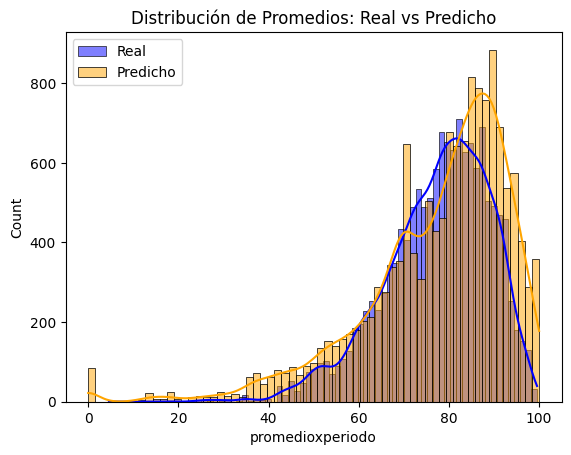

In [279]:
# Comparar distribución entre predicciones y valores reales
import seaborn as sns

sns.histplot(dataperiodos['promedioxperiodo'], label='Real', color='blue', kde=True)
sns.histplot(dataperiodos['promedio'], label='Predicho', color='orange', kde=True)
plt.legend()
plt.title('Distribución de Promedios: Real vs Predicho')
plt.show()

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error



### Presentamos los datos, eliminando filas y columnas que no sirvan

In [280]:
dataperiodos.drop('ingreso', axis=1, inplace=True)
dataperiodos.drop('termino', axis=1, inplace=True)
dataperiodos.drop('ultimo_digito', axis=1, inplace=True)
dataperiodos.drop('anio_ingreso', axis=1, inplace=True)
dataperiodos.drop('periodo', axis=1, inplace=True)

### Agregamos una nueva columna para identificar alos alumnos que estan en riesgo de tener bajo rendimiento academico en cierto periodo

In [281]:
dataperiodos
umbral = 70
dataperiodos['alumnoEnRiesgoBajoRendimiento'] = dataperiodos['promedioxperiodo'].apply(lambda x: "En riesgo" if x < umbral else "Sin riesgo")
dataperiodos.to_csv('dataperiodosnuevo.csv',index=False)